# HVAC Hybrid Model

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import xgboost as xgb
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

import seaborn as sns 
import matplotlib.pyplot as plt

np.random.seed(42)

In [2]:
hvac_data = pd.read_csv('/Users/manraj/Documents/GitHub/Dana-4830/HVAC_Test_Data_Files/hvac.csv')
print('HVAC Data Shape:', hvac_data.shape)
hvac_data.head()

HVAC Data Shape: (52561, 34)


,b'Environment:Site Outdoor Air Relative Humidity[%]',b'Environment:Site Outdoor Air Dewpoint Temperature[C]',b'Electricity:HVAC[J]',b'Environment:Site Outdoor Air Wetbulb Temperature[C]',b'CLASSROOM_BOT ZN:Zone People Occupant Count[]',b'CONFROOM_BOT_1 ZN:Zone People Occupant Count[]',b'CONFROOM_BOT_2 ZN:Zone People Occupant Count[]',b'CONFROOM_MID_1 ZN:Zone People Occupant Count[]',b'CONFROOM_MID_2 ZN:Zone People Occupant Count[]',b'CONFROOM_TOP_1 ZN:Zone People Occupant Count[]',...,b'OPENOFFICE_MID_1 ZN:Zone People Occupant Count[]',b'OPENOFFICE_MID_2 ZN:Zone People Occupant Count[]',b'OPENOFFICE_MID_3 ZN:Zone People Occupant Count[]',b'OPENOFFICE_MID_4 ZN:Zone People Occupant Count[]',b'OPENOFFICE_TOP_1 ZN:Zone People Occupant Count[]',b'OPENOFFICE_TOP_2 ZN:Zone People Occupant Count[]',b'OPENOFFICE_TOP_3 ZN:Zone People Occupant Count[]',b'OPENOFFICE_TOP_4 ZN:Zone People Occupant Count[]',b'Environment:Site Day Type Index[]',b'Environment:Site Outdoor Air Drybulb Temperature[C]'
0,0.000000,0.00,0.000000e+00,0.000000,0.0,1.0,2.0,3.0,4.0,5.0,...,20.0,21.0,22.0,23.0,24.0,25.0,26.0,27.0,0.0,0.000000
1,83.666667,16.95,1.497632e+06,17.949119,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,19.816667
2,84.333333,16.90,5.228360e+06,17.853131,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,19.633333
3,85.000000,16.85,7.935451e+06,17.756143,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,19.450000
4,85.666667,16.80,2.509377e+06,17.658150,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,19.266667


In [3]:
hvac_data.columns = hvac_data.columns.str.replace(r"^b'|'$|\[.*?\]", "", regex=True)

In [4]:
hvac_data = hvac_data.loc[hvac_data['Environment:Site Day Type Index'] != 0]
hvac_data["HVAC_kWh"] = hvac_data["Electricity:HVAC"] * 2.77778e-7
hvac_data.drop(columns='Electricity:HVAC', axis=1, inplace=True)

In [5]:
occupant_cols = [col for col in hvac_data.columns if 'Occupant' in col]
hvac_data["TotalOccCount"] = hvac_data[occupant_cols].sum(axis=1)
hvac_data.drop(columns=occupant_cols, axis=1, inplace=True)

In [6]:
time_shifts = [0.5, 1]

for h in time_shifts:
    steps = int(h * 6)
    hvac_data[f"Occ_minus{int(h*60)}"] = hvac_data["TotalOccCount"].shift(steps)

for h in time_shifts:
    steps = int(h * 6)
    hvac_data[f"Occ_plus{int(h*60)}"] = hvac_data["TotalOccCount"].shift(-steps)

In [7]:
def map_day_type(x):
    if x in [0, 6, 7]:
        return 1
    else:
        return 0

hvac_data["WeekendOrHoliday"] = hvac_data["Environment:Site Day Type Index"].apply(map_day_type)

In [8]:
lenOfData = len(hvac_data)
hvac_data.index = pd.date_range(start="2004-01-01 00:00:00", periods=lenOfData, freq="10min")

In [9]:
hvac_data.head()

,Environment:Site Outdoor Air Relative Humidity,Environment:Site Outdoor Air Dewpoint Temperature,Environment:Site Outdoor Air Wetbulb Temperature,Environment:Site Day Type Index,Environment:Site Outdoor Air Drybulb Temperature,HVAC_kWh,TotalOccCount,Occ_minus30,Occ_minus60,Occ_plus30,Occ_plus60,WeekendOrHoliday
2004-01-01 00:00:00,83.666667,16.95,17.949119,1.0,19.816667,0.416009,0.0,NaN,NaN,0.0,0.0,0
2004-01-01 00:10:00,84.333333,16.90,17.853131,1.0,19.633333,1.452323,0.0,NaN,NaN,0.0,0.0,0
2004-01-01 00:20:00,85.000000,16.85,17.756143,1.0,19.450000,2.204294,0.0,NaN,NaN,0.0,0.0,0
2004-01-01 00:30:00,85.666667,16.80,17.658150,1.0,19.266667,0.697050,0.0,0.0,NaN,0.0,0.0,0
2004-01-01 00:40:00,86.333333,16.75,17.559176,1.0,19.083333,1.474651,0.0,0.0,NaN,0.0,0.0,0


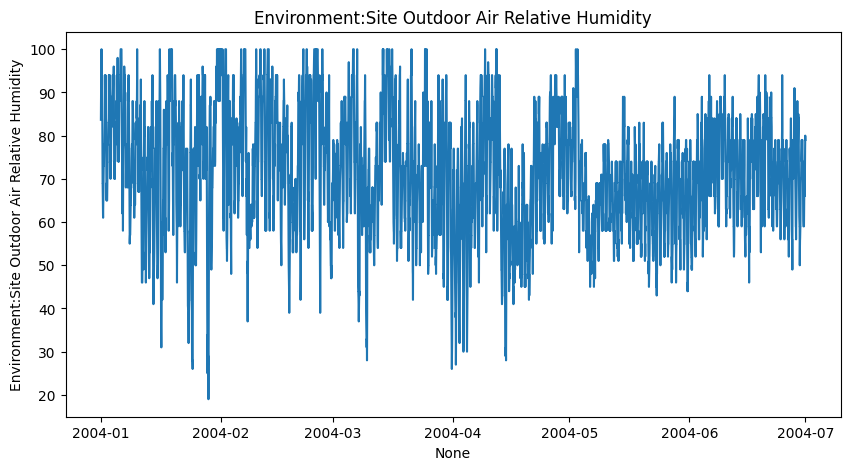

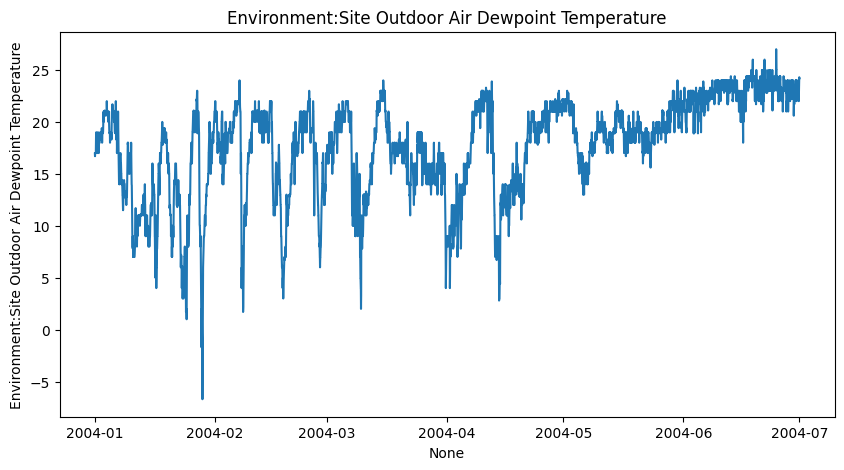

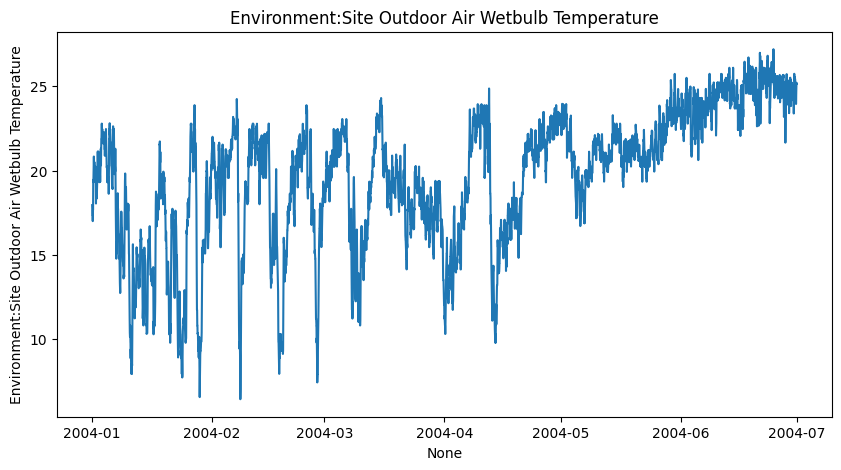

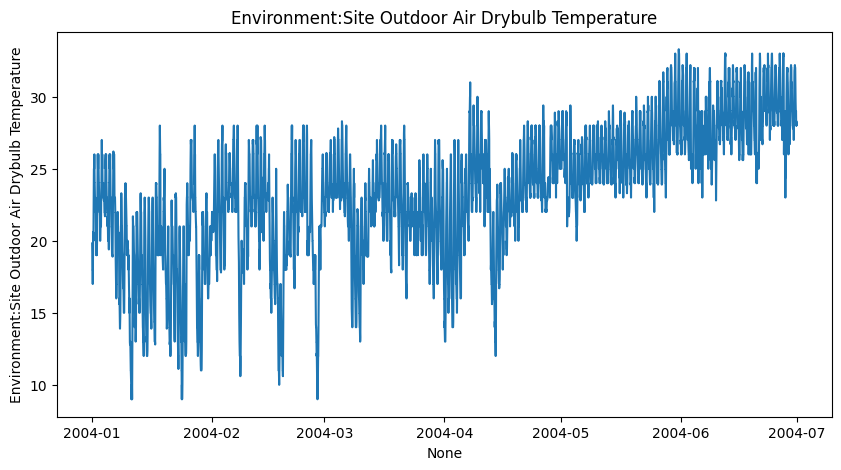

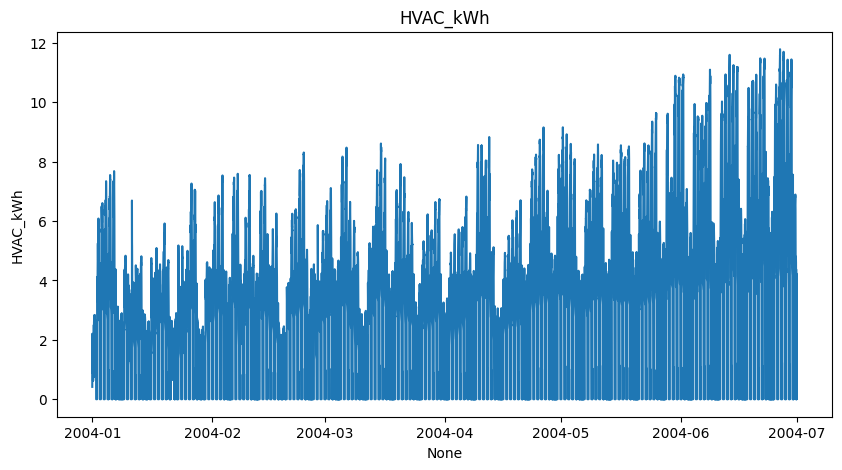

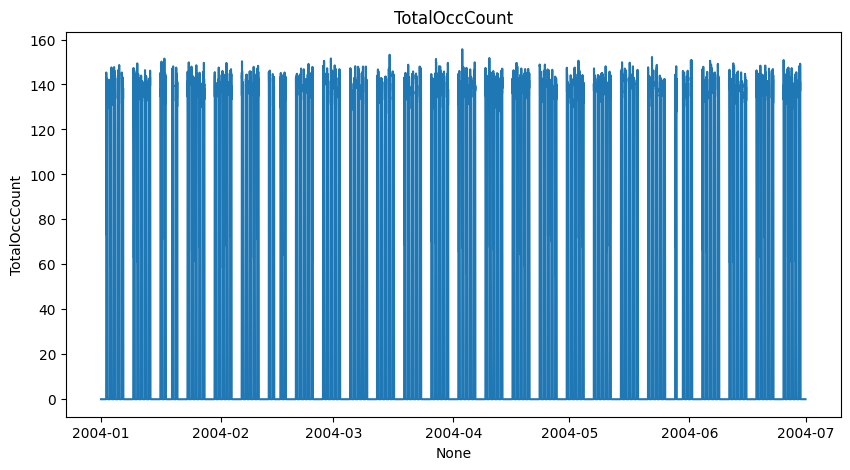

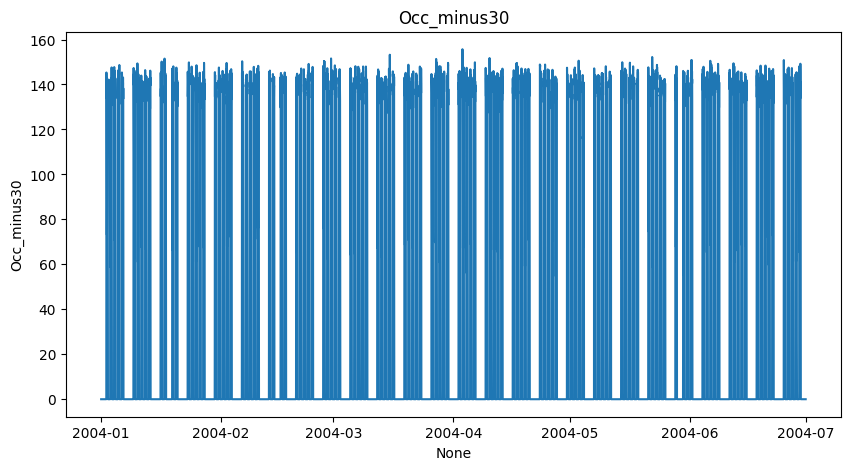

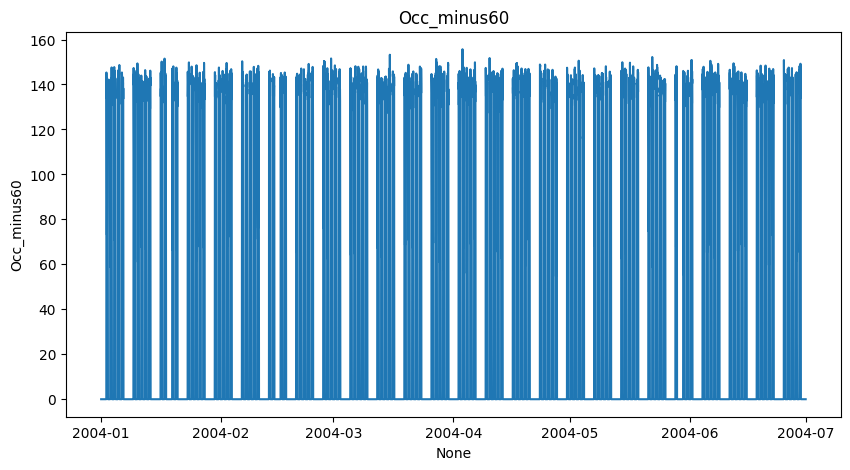

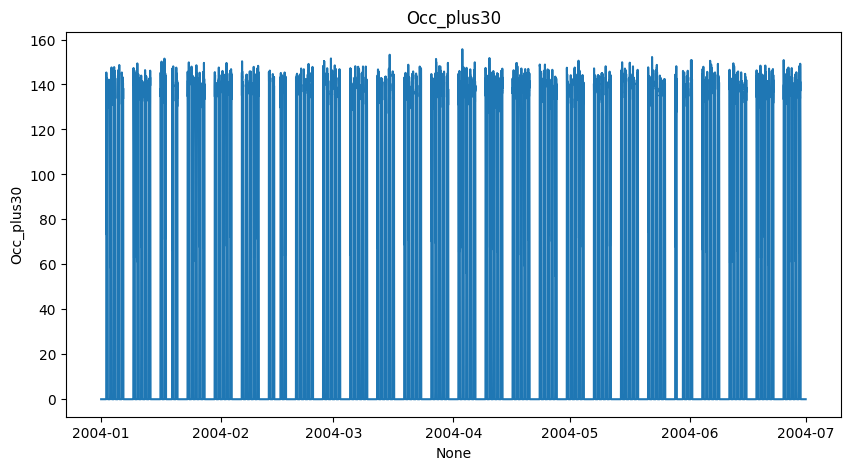

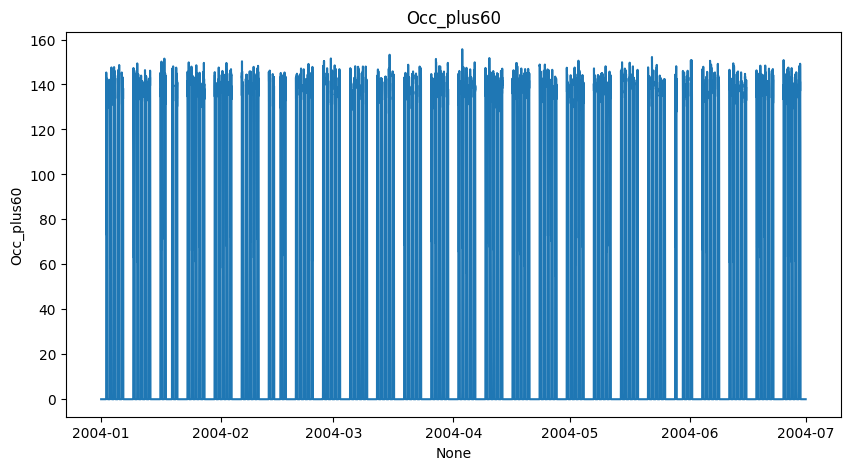

In [10]:
for col in ['Environment:Site Outdoor Air Relative Humidity',
       'Environment:Site Outdoor Air Dewpoint Temperature',
       'Environment:Site Outdoor Air Wetbulb Temperature',
       'Environment:Site Outdoor Air Drybulb Temperature', 'HVAC_kWh',
       'TotalOccCount', 'Occ_minus30', 'Occ_minus60', 'Occ_plus30',
       'Occ_plus60']:
    plt.figure(figsize=(10,5))
    sns.lineplot(x=hvac_data.index[hvac_data.index.month < 7], y = hvac_data[col][hvac_data.index.month < 7])
    plt.title(f'{col}')
    plt.show()

In [11]:
def create_features(df):
    df = df.copy()
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.isocalendar().week
    
    return df

hvac_data = create_features(hvac_data)

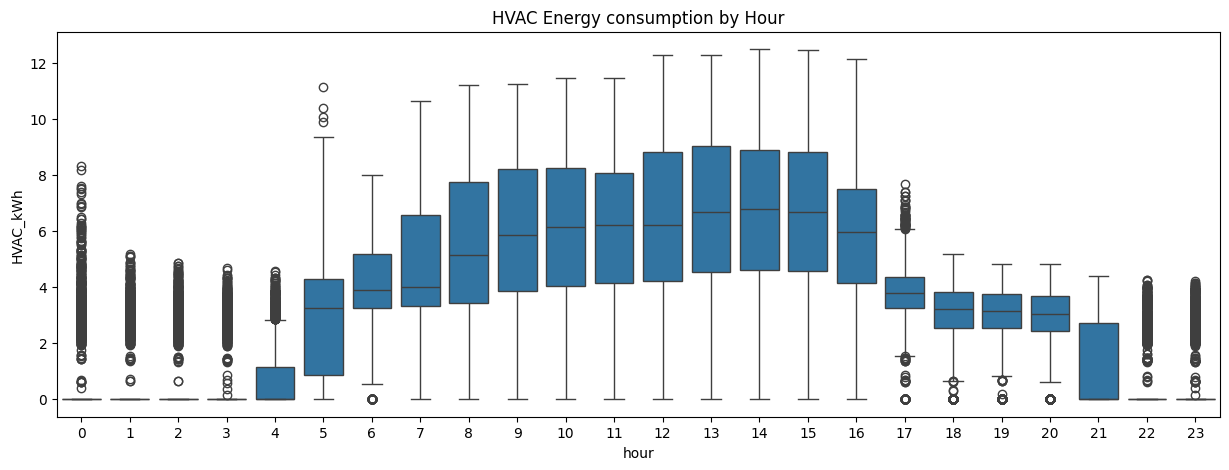

In [12]:
fig, ax = plt.subplots(figsize=(15, 5))
sns.boxplot(x='hour', y='HVAC_kWh', data=hvac_data, ax=ax)
plt.title('HVAC Energy consumption by Hour')
plt.show()

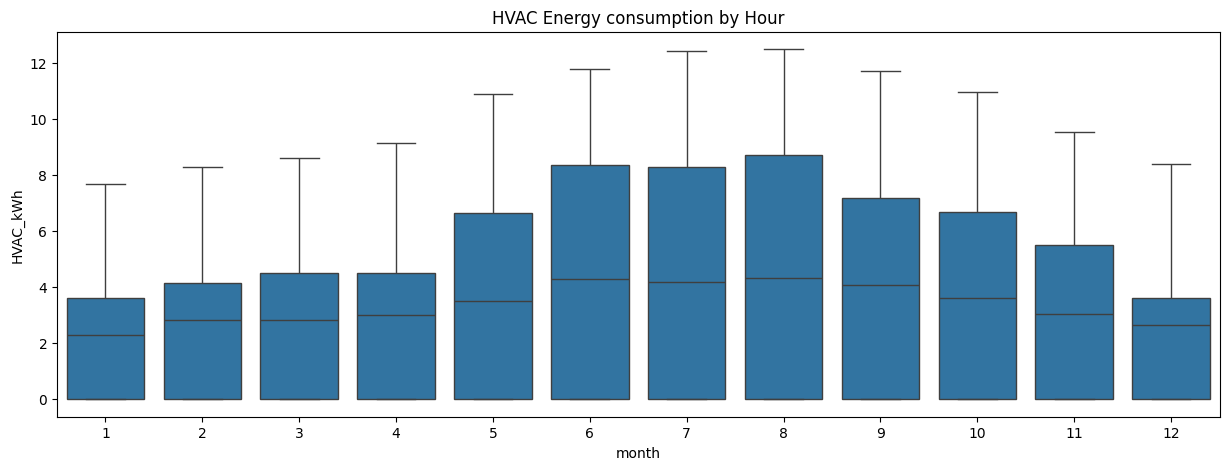

In [13]:
fig, ax = plt.subplots(figsize=(15, 5))
sns.boxplot(x='month', y='HVAC_kWh', data=hvac_data, ax=ax)
plt.title('HVAC Energy consumption by Hour')
plt.show()

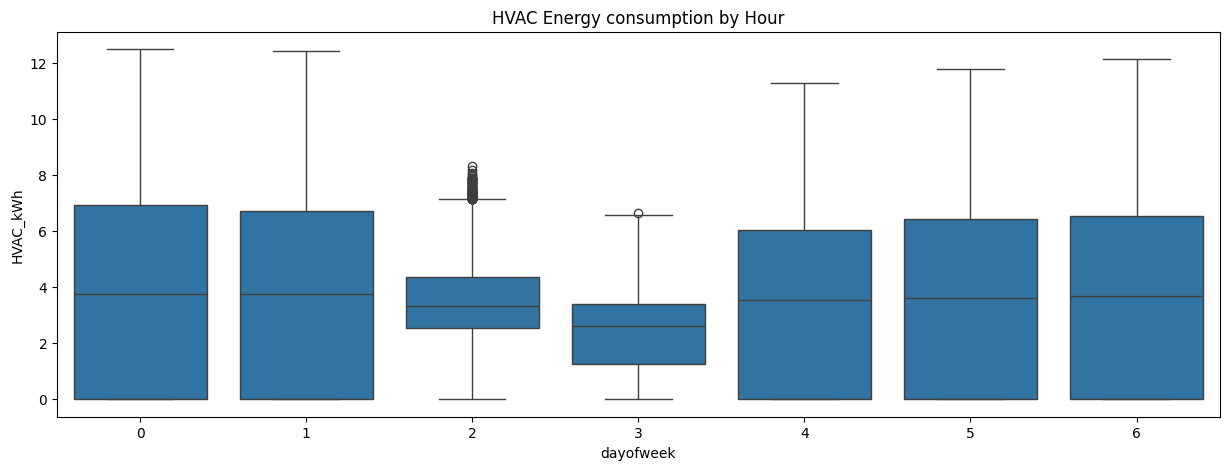

In [14]:
fig, ax = plt.subplots(figsize=(15, 5))
sns.boxplot(x='dayofweek', y='HVAC_kWh', data=hvac_data, ax=ax)
plt.title('HVAC Energy consumption by Hour')
plt.show()

In [15]:
original_data = hvac_data.copy()

In [16]:
features = [col for col in hvac_data.columns if col not in ['HVAC_kWh']]
target = 'HVAC_kWh'

In [17]:
x_train, y_train = hvac_data[features][hvac_data.index.month < 10], hvac_data[target][hvac_data.index.month < 10]
x_test, y_test = hvac_data[features][hvac_data.index.month >= 10], hvac_data[target][hvac_data.index.month >= 10]

In [18]:
def compute_metrics(test_data,forecast_mean):
    mae = mean_absolute_error(test_data, forecast_mean)
    mse = mean_squared_error(test_data, forecast_mean)
    rmse = np.sqrt(mse)


    metrics = {
        "mae":mae,
        "mse":mse,
        "rmse":rmse
    }

    return metrics

### XGB Boost

In [19]:
reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',    
                       n_estimators=1000,
                #        early_stopping_rounds=50,
                       objective='reg:linear',
                       max_depth=3,
                       learning_rate=0.01)
reg.fit(x_train, y_train,
        verbose=100)

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [22:55:45] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, objective='reg:linear', ...)

In [20]:
pred_data_1 = reg.predict(x_test)

In [21]:
pred_df_1 = hvac_data[hvac_data.index.month >= 10]

In [22]:
pred_df_1['Predictions'] = pred_data_1

/var/folders/9p/w309j4n94633ymfb_v3x990r0000gn/T/ipykernel_83220/1893648079.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_df_1['Predictions'] = pred_data_1


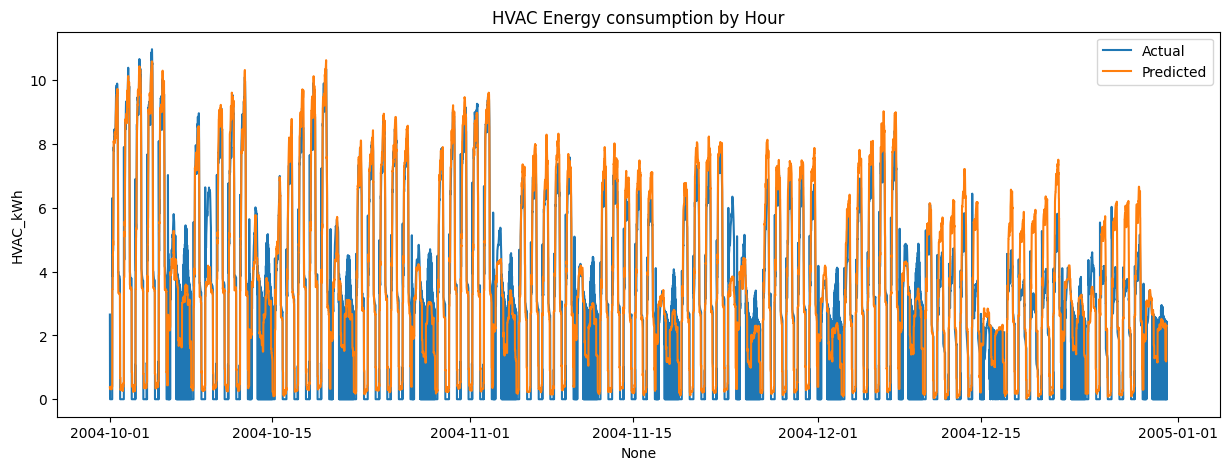

In [23]:
plt.figure(figsize=(15, 5))
sns.lineplot(x=pred_df_1.index, y=pred_df_1['HVAC_kWh'], label='Actual')
sns.lineplot(x=pred_df_1.index, y=pred_df_1['Predictions'], label='Predicted')
plt.title('HVAC Energy consumption by Hour')
plt.legend()
plt.show()

In [24]:
compute_metrics(pred_df_1['HVAC_kWh'], pred_df_1['Predictions'])

{'mae': 0.7494853017520872, 'mse': 1.0819751905938, 'rmse': 1.0401803644531078}

### Hybrid

In [25]:
x_train = x_train.bfill()

In [26]:
lin_reg_hybrid = LinearRegression()
lin_reg_hybrid.fit(x_train, y_train)

y_train_residuals = y_train - pd.Series(lin_reg_hybrid.predict(x_train), index=x_train.index)
y_train_hybrid = y_train_residuals
xgb_reg_hybrid = xgb.XGBRegressor(base_score=0.5,
                      booster='gbtree',
                      n_estimators=200,
                      objective='reg:squarederror',
                      max_depth=5,
                      learning_rate=0.05)
xgb_reg_hybrid.fit(x_train, y_train_hybrid,
       verbose=100)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.05, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=200, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

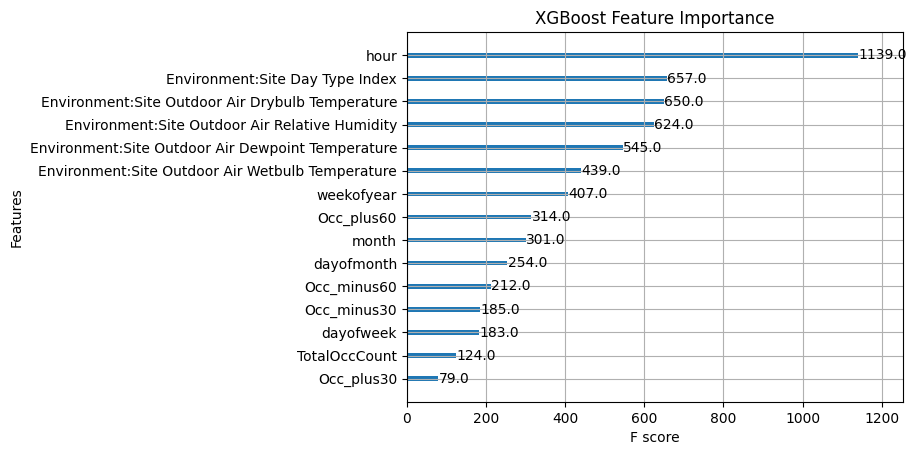

In [27]:
xgb.plot_importance(xgb_reg_hybrid)
plt.title("XGBoost Feature Importance")
plt.show()

In [28]:
x_test = x_test.ffill()
x_test.head()

,Environment:Site Outdoor Air Relative Humidity,Environment:Site Outdoor Air Dewpoint Temperature,Environment:Site Outdoor Air Wetbulb Temperature,Environment:Site Day Type Index,Environment:Site Outdoor Air Drybulb Temperature,TotalOccCount,Occ_minus30,Occ_minus60,Occ_plus30,Occ_plus60,WeekendOrHoliday,hour,dayofweek,month,year,dayofmonth,weekofyear
2004-10-01 00:00:00,74.833333,22.033333,23.367234,2.0,26.85,0.0,0.0,0.0,0.0,0.0,0,0,4,10,2004,1,40
2004-10-01 00:10:00,75.666667,22.066667,23.351231,2.0,26.70,0.0,0.0,0.0,0.0,0.0,0,0,4,10,2004,1,40
2004-10-01 00:20:00,76.500000,22.100000,23.333793,2.0,26.55,0.0,0.0,0.0,0.0,0.0,0,0,4,10,2004,1,40
2004-10-01 00:30:00,77.333333,22.133333,23.314965,2.0,26.40,0.0,0.0,0.0,0.0,0.0,0,0,4,10,2004,1,40
2004-10-01 00:40:00,78.166667,22.166667,23.294748,2.0,26.25,0.0,0.0,0.0,0.0,0.0,0,0,4,10,2004,1,40


In [29]:
#Making Predictions on test set
y_pred_lin_reg = lin_reg_hybrid.predict(x_test[features])
y_pred_xgb_reg = xgb_reg_hybrid.predict(x_test[features])

y_pred_combined = y_pred_lin_reg + y_pred_xgb_reg
y_pred_combined = pd.Series(y_pred_combined, index = x_test[features].index)

In [30]:
pred_df_hybrid = hvac_data[(hvac_data.index.month >= 10) & (hvac_data.index.month <= 11)]

In [31]:
pred_df_hybrid['Predictions'] = y_pred_combined

/var/folders/9p/w309j4n94633ymfb_v3x990r0000gn/T/ipykernel_83220/2465434815.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_df_hybrid['Predictions'] = y_pred_combined


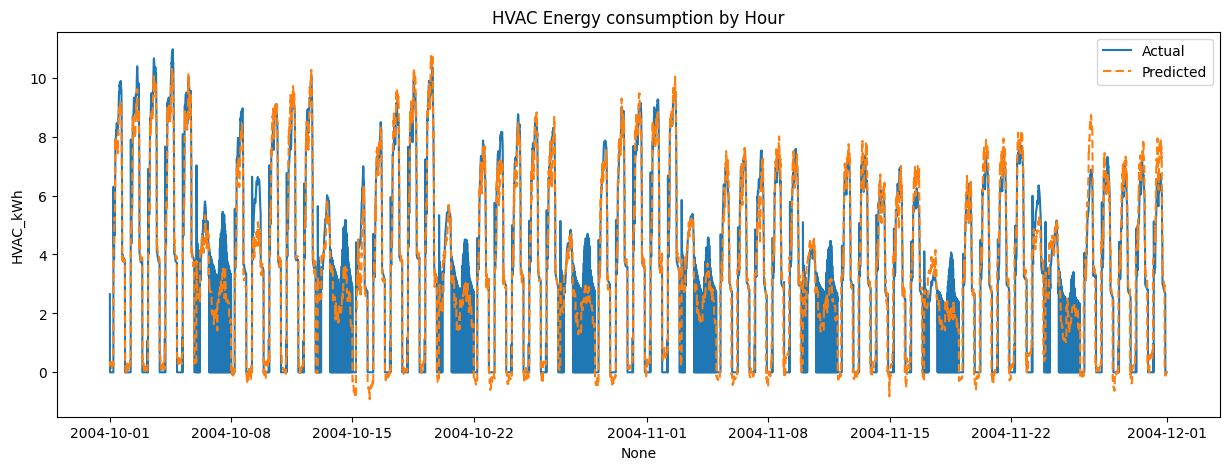

In [32]:
plt.figure(figsize=(15, 5))
sns.lineplot(x=pred_df_hybrid.index, y=pred_df_hybrid['HVAC_kWh'], label='Actual')
sns.lineplot(x=pred_df_hybrid.index, y=pred_df_hybrid['Predictions'], label='Predicted', dashes=(4,2))
plt.title('HVAC Energy consumption by Hour')
plt.legend()
plt.show()

In [33]:
compute_metrics(pred_df_hybrid['HVAC_kWh'], pred_df_hybrid['Predictions'])

{'mae': 0.6216963549567514,
 'mse': 0.8862087927570086,
 'rmse': 0.9413866329819054}

### Hybrid with Lags

In [34]:
hvac_data = original_data.copy()

In [35]:
# target_map = hvac_data['HVAC_kWh'].to_dict()
for col in hvac_data.columns:
    hvac_data[f'lag1{col}'] = hvac_data[f'{col}'].shift(144*7)
    hvac_data[f'lag2{col}'] = hvac_data[f'{col}'].shift(144*14)
    hvac_data[f'lag3{col}'] = hvac_data[f'{col}'].shift(144*21)

In [36]:
features = [col for col in hvac_data.columns if col not in ['HVAC_kWh']]
target = 'HVAC_kWh'

In [37]:
x_train, y_train = hvac_data[features][hvac_data.index.month < 10], hvac_data[target][hvac_data.index.month < 10]
x_test, y_test = hvac_data[features][hvac_data.index.month >= 10], hvac_data[target][hvac_data.index.month >= 10]

In [38]:
features = [col for col in hvac_data.columns if col not in ['HVAC_kWh']]
target = 'HVAC_kWh'

In [39]:
x_train = x_train.bfill()
x_train = x_train.ffill()

In [40]:
lin_reg_hybrid_lags = LinearRegression()
lin_reg_hybrid_lags.fit(x_train, y_train)

y_train_residuals_hybrid_lags = y_train - pd.Series(lin_reg_hybrid_lags.predict(x_train), index=x_train.index)
y_train_hybrid_lags = y_train_residuals_hybrid_lags
xgb_reg_hybrid_lags = xgb.XGBRegressor(base_score=0.5,
                      booster='gbtree',
                      n_estimators=200,
                      objective='reg:squarederror',
                      max_depth=5,
                      learning_rate=0.05)
xgb_reg_hybrid_lags.fit(x_train, y_train_hybrid_lags,
       verbose=100)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.05, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=200, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

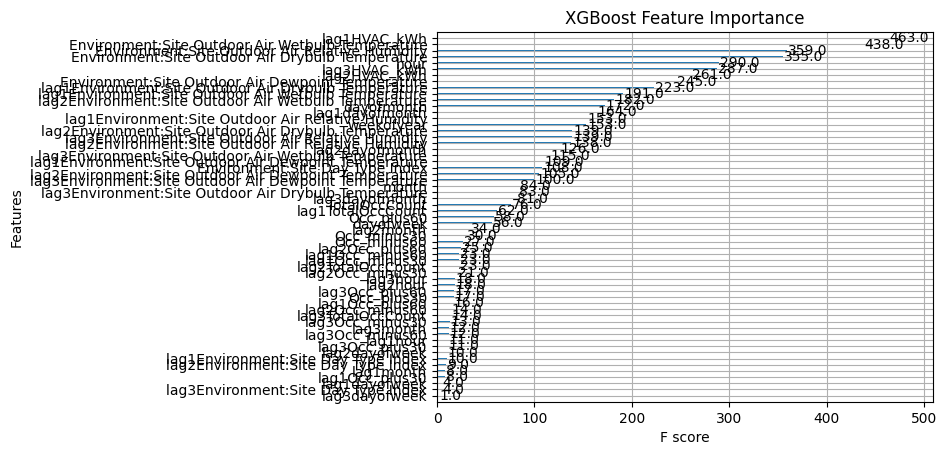

In [41]:
xgb.plot_importance(xgb_reg_hybrid_lags)
plt.title("XGBoost Feature Importance")
plt.show()

In [42]:
x_test = x_test.ffill()

In [43]:
y_pred_lin_reg_lags = lin_reg_hybrid_lags.predict(x_test)
y_pred_xgb_reg_lags = xgb_reg_hybrid_lags.predict(x_test)

y_pred_combined_lags = y_pred_lin_reg_lags + y_pred_xgb_reg_lags
y_pred_combined_lags = pd.Series(y_pred_combined_lags, index = x_test.index)

In [44]:
pred_df_hybrid_lags = hvac_data[(hvac_data.index.month >= 10) & (hvac_data.index.month <= 10)]

In [45]:
pred_df_hybrid_lags['Predictions'] = y_pred_combined_lags

/var/folders/9p/w309j4n94633ymfb_v3x990r0000gn/T/ipykernel_83220/243560393.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_df_hybrid_lags['Predictions'] = y_pred_combined_lags


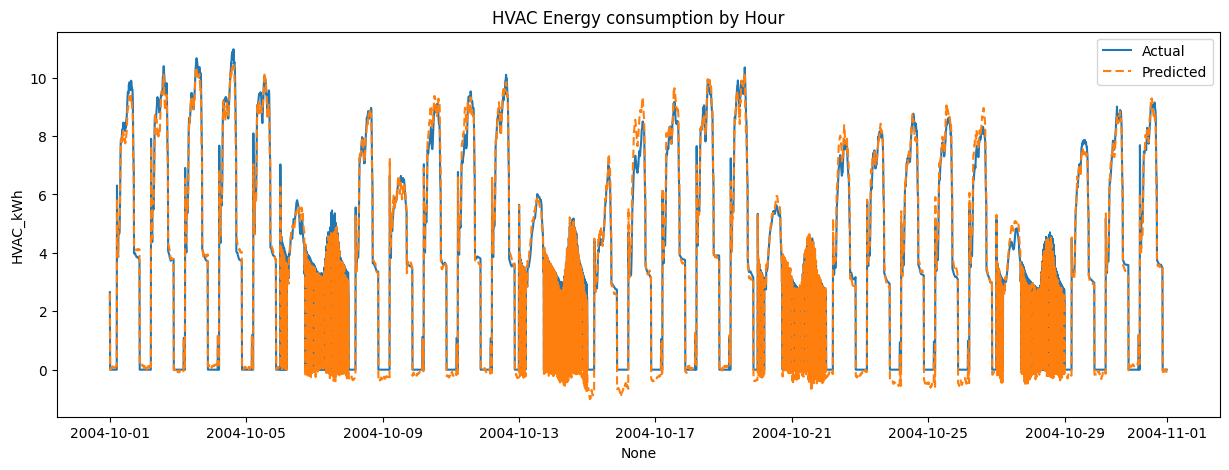

In [46]:
plt.figure(figsize=(15, 5))
sns.lineplot(x=pred_df_hybrid_lags.index, y=pred_df_hybrid_lags['HVAC_kWh'], label='Actual')
sns.lineplot(x=pred_df_hybrid_lags.index, y=pred_df_hybrid_lags['Predictions'], label='Predicted', dashes=(4,2))
plt.title('HVAC Energy consumption by Hour')
plt.legend()
plt.show()

In [47]:
compute_metrics(pred_df_hybrid_lags['HVAC_kWh'], pred_df_hybrid_lags['Predictions'])

{'mae': 0.24071399353091938,
 'mse': 0.10527098555195658,
 'rmse': 0.32445490526721366}

### Extract top 10 features from Hybrid with Lags model


In [48]:
xgb_importance = pd.Series(xgb_reg_hybrid_lags.feature_importances_, index=x_train.columns)
xgb_importance_sorted = xgb_importance.sort_values(ascending=False)

print("XGBoost Feature Importances:")
print(xgb_importance_sorted[:15])

top_15_features = xgb_importance_sorted[:15].index.tolist()

XGBoost Feature Importances:
lag3TotalOccCount                                       0.133556
TotalOccCount                                           0.086409
Environment:Site Outdoor Air Wetbulb Temperature        0.049915
lag1TotalOccCount                                       0.039600
weekofyear                                              0.036779
month                                                   0.035964
lag1hour                                                0.031475
lag3dayofweek                                           0.029095
lag3HVAC_kWh                                            0.023377
Environment:Site Outdoor Air Drybulb Temperature        0.023044
lag3Occ_minus30                                         0.022050
lag1HVAC_kWh                                            0.021562
lag2hour                                                0.021413
lag1Environment:Site Outdoor Air Wetbulb Temperature    0.020348
lag2Environment:Site Outdoor Air Wetbulb Temperature    0.018

In [49]:
lin_reg_hybrid_lags = LinearRegression()
lin_reg_hybrid_lags.fit(x_train[top_15_features], y_train)

y_train_residuals_hybrid_lags = y_train - pd.Series(lin_reg_hybrid_lags.predict(x_train[top_15_features]), index=x_train.index)

y_train_hybrid_lags = y_train_residuals_hybrid_lags
xgb_reg_hybrid_lags = xgb.XGBRegressor(base_score=0.5,
                      booster='gbtree',
                      n_estimators=200,
                      objective='reg:squarederror',
                      max_depth=5,
                      learning_rate=0.05)
xgb_reg_hybrid_lags.fit(x_train[top_15_features], y_train_hybrid_lags,
       verbose=100)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.05, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=200, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [50]:
y_pred_lin_reg_lags = lin_reg_hybrid_lags.predict(x_test[top_15_features])
y_pred_xgb_reg_lags = xgb_reg_hybrid_lags.predict(x_test[top_15_features])

y_pred_combined_lags = y_pred_lin_reg_lags + y_pred_xgb_reg_lags
y_pred_combined_lags = pd.Series(y_pred_combined_lags, index = x_test.index)

/var/folders/9p/w309j4n94633ymfb_v3x990r0000gn/T/ipykernel_83220/3065555433.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_df_hybrid_lags['Predictions'] = y_pred_combined_lags


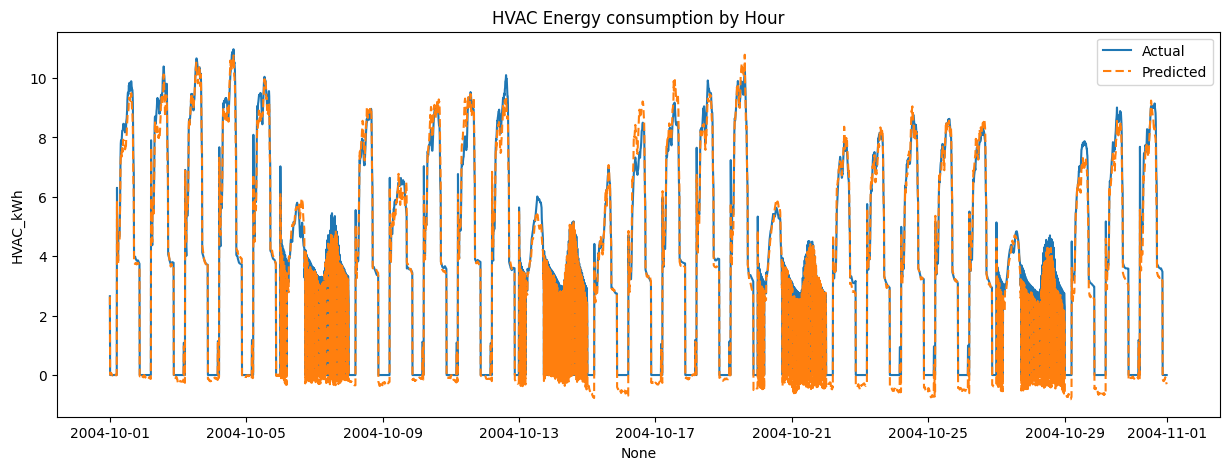

{'mae': 0.29256691712805444,
 'mse': 0.14261455349826468,
 'rmse': 0.3776434210975543}

In [51]:
pred_df_hybrid_lags = hvac_data[(hvac_data.index.month >= 10) & (hvac_data.index.month <= 10)]
pred_df_hybrid_lags['Predictions'] = y_pred_combined_lags
plt.figure(figsize=(15, 5))
sns.lineplot(x=pred_df_hybrid_lags.index, y=pred_df_hybrid_lags['HVAC_kWh'], label='Actual')
sns.lineplot(x=pred_df_hybrid_lags.index, y=pred_df_hybrid_lags['Predictions'], label='Predicted', dashes=(4,2))
plt.title('HVAC Energy consumption by Hour')
plt.legend()
plt.show()
compute_metrics(pred_df_hybrid_lags['HVAC_kWh'], pred_df_hybrid_lags['Predictions'])